# Titanic : Machine Learning from Disaster

### 1. Importing the dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S
56,57,1,2,"Rugg, Miss. Emily",female,21.0,0,0,C.A. 31026,10.5000,NaN,S
408,409,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,312992,7.7750,NaN,S


In [3]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Transforming Features

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(30)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 100)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenage', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

In [6]:
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [7]:
def simplify_fares(df):
    df.Fare = df.Fare.fillna(32)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

In [8]:
def simplify_embarked(df):
    df.Embarked = df.Embarked.fillna('S')
    return df

In [9]:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df  

In [10]:
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

In [11]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = simplify_embarked(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [12]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,S,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,S,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,S,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,S,"Allen,",Mr.


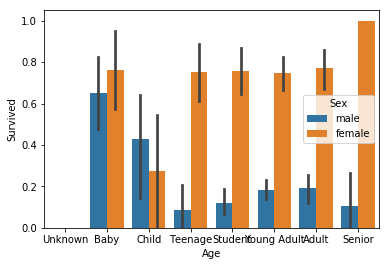

In [13]:
sns.barplot(x = "Age", y = "Survived", hue = "Sex", data=data_train)

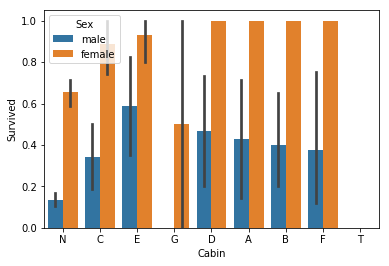

In [14]:
sns.barplot(x = "Cabin", y = "Survived", hue = "Sex", data=data_train)


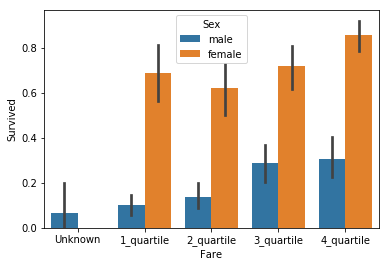

In [15]:
sns.barplot(x = "Fare", y = "Survived", hue = "Sex", data=data_train)


### Encoding

In [16]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix',"Embarked"]
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,2,100,19
1,2,1,1,0,0,1,0,3,2,0,182,20
2,3,1,3,0,6,0,0,0,7,2,329,16
3,4,1,1,0,6,1,0,3,2,2,267,20
4,5,0,3,1,6,0,0,1,7,2,15,19


### Machine Learning

In [17]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.832402234637


### Validate with Kfold

In [20]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.8
Fold 2 accuracy: 0.8539325842696629
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.8314606741573034
Fold 5 accuracy: 0.8314606741573034
Fold 6 accuracy: 0.8202247191011236
Fold 7 accuracy: 0.797752808988764
Fold 8 accuracy: 0.8202247191011236
Fold 9 accuracy: 0.8651685393258427
Fold 10 accuracy: 0.8314606741573034
Mean Accuracy: 0.823820224719101


### Predict the Actual Test Data

In [21]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [22]:
output.shape

(418, 2)

In [23]:
output.to_csv("result1.csv",index=False)